In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
car = pd.read_csv('C://Users//khara//End_to_end_project//Quikrcarpriceprediction//Quikr cars.csv') 

In [3]:
car.head()

,Name,Price,Kms_driven,Fuel_type,Year,Company
0,Ford Figo Duratec Petrol EXI 1.2 - 2015,"3,80,000","35,056 kms",Petrol,2015,Ford
1,Maruti Suzuki Wagon R VXI BS IV - 2016,"4,65,000","44,000 kms",Petrol,2016,Maruti
2,Hyundai Creta 1.6 SX PLUS AUTO PETROL - 2018,"13,50,000","42,917 kms",Petrol,2018,Hyundai
3,Hyundai Venue - 2019,"10,19,699","16,112 kms",Petrol,2019,Hyundai
4,Honda Jazz - 2017,"7,13,499","30,988 kms",Petrol,2017,Honda


In [4]:
from platform import python_version

print(python_version())

3.8.18


In [5]:
car.shape

(1028, 6)

In [6]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        1028 non-null   object
 1   Price       1028 non-null   object
 2   Kms_driven  1028 non-null   object
 3   Fuel_type   1028 non-null   object
 4   Year        1028 non-null   int64 
 5   Company     1028 non-null   object
dtypes: int64(1), object(5)
memory usage: 48.3+ KB


# Data Cleaning 

In [7]:
#Year is in int64. Change to int32.
car['Year']=car['Year'].astype(int)

In [8]:
#Price has Ask for Price
car=car[car['Price']!='Ask For Price']

In [9]:
#Price has commas in its prices and is in object
car['Price']=car['Price'].str.replace(',','').astype(int)

In [10]:
#Kms_driven has object values with kms at last.
car['Kms_driven']=car['Kms_driven'].str.split().str.get(0).str.replace(',','')

In [11]:
car=car[car['Kms_driven'].str.isnumeric()]

In [12]:
car['Kms_driven']=car['Kms_driven'].astype(int)

In [13]:
car.shape

(1022, 6)

In [14]:
#Company does not need any cleaning now. Changing car names. Keeping only the first three words
car['Name']=car['Name'].str.split().str.slice(start=0,stop=3).str.join(' ')

In [15]:
#Resetting the index of the final cleaned data
car=car.reset_index(drop=True)

In [16]:
# Remove '-' from the end of strings in the 'Name' column
car['Name'] = car['Name'].str.rstrip('- ').str.strip()

In [17]:
car.head()

,Name,Price,Kms_driven,Fuel_type,Year,Company
0,Ford Figo Duratec,380000,35056,Petrol,2015,Ford
1,Maruti Suzuki Wagon,465000,44000,Petrol,2016,Maruti
2,Hyundai Creta 1.6,1350000,42917,Petrol,2018,Hyundai
3,Hyundai Venue,1019699,16112,Petrol,2019,Hyundai
4,Honda Jazz,713499,30988,Petrol,2017,Honda


In [18]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        1022 non-null   object
 1   Price       1022 non-null   int32 
 2   Kms_driven  1022 non-null   int32 
 3   Fuel_type   1022 non-null   object
 4   Year        1022 non-null   int32 
 5   Company     1022 non-null   object
dtypes: int32(3), object(3)
memory usage: 36.1+ KB


In [19]:
#car.to_csv('Cleaned_Car_data.csv')

# Extracting Training Data

In [20]:
# Define features (X) and target (y) for both models

X_model1 = car[['Company', 'Name', 'Year', 'Kms_driven', 'Fuel_type']]
y_model1 = car['Price']

X_model2 = car[['Company', 'Name', 'Year', 'Kms_driven', 'Fuel_type']]
y_model2 = car['Price']

In [21]:
# Preprocessing pipeline for both models
categorical_features = ['Company', 'Name', 'Fuel_type']
numerical_features = ['Year', 'Kms_driven']

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

In [22]:
# Train model 1
quantiles = [0.05, 0.95]
quantile_regressors = {}
for quantile in quantiles:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(loss='quantile', alpha=quantile))
    ])
    pipeline.fit(X_model1, y_model1)
    quantile_regressors[quantile] = pipeline

In [23]:
# Train model 2
X_train, X_test, y_train, y_test = train_test_split(X_model2, y_model2, test_size=0.1)
ohe = OneHotEncoder()
ohe.fit(car[['Company', 'Fuel_type', 'Name']])
column_trans = make_column_transformer(
    (OneHotEncoder(categories=ohe.categories_), ['Company', 'Fuel_type', 'Name']),
    remainder='passthrough')
lr = LinearRegression()
pipe = make_pipeline(column_trans, lr)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['Audi', 'BMW', 'Chevrolet', 'Datsun', 'Fiat', 'Ford', 'Honda',
       'Hyundai', 'Jaguar', 'Jeep', 'Kia', 'Land', 'MG', 'Mahindra',
       'Maruti', 'Mercedes', 'Nissan', 'Renault', 'Skoda', 'Ssangyong',
       'Tata', 'Toyota', 'Volkswagen', 'Volvo']...
       'Volkswagen Ameo', 'Volkswagen Ameo Comfortline',
       'Volkswagen Polo', 'Volkswagen Polo COMFORTLINE',
       'Volkswagen Polo Comfortline', 'Volkswagen Polo GT',
       'Volkswagen Polo HIGHLINE1.2L', 'Volkswagen Polo Highline',
       'Volkswagen Vento', 'Volkswagen Vento Highline', 'Volvo XC60 D3',
       'Volvo XC90 D5'], dtype=object)]),
                                                  ['Company', 'Fuel_type',
                                                   'Name'])])),
                ('linearregression', LinearRegression())])

In [24]:
from sklearn.metrics import r2_score
max_score = 0
optimal_random_state = None
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X_model2,y_model2, test_size=0.1, random_state=i)
    lr = LinearRegression()
    pipe = make_pipeline(column_trans, lr)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    score = r2_score(y_test, y_pred)
    if score > max_score:
        max_score = score
        optimal_random_state = i

print("Optimal Random State:", optimal_random_state)
print("R2 Score:", max_score)

Optimal Random State: 409
R2 Score: 0.8576704946776718


In [25]:
# Use the optimal random state to split the data
X_train, X_test, y_train, y_test = train_test_split(X_model2,y_model2, test_size=0.1, random_state=optimal_random_state)

# Create and train the linear regression model
lr = LinearRegression()
pipe = make_pipeline(column_trans, lr)
pipe.fit(X_train, y_train)

# Evaluate the model
y_pred = pipe.predict(X_test)
score = r2_score(y_test, y_pred)

print("Optimal Random State:", optimal_random_state)
print("R2 Score:", score)

Optimal Random State: 409
R2 Score: 0.8576704946776718


In [26]:
# Use the optimal random state to split the data
X_train, X_test, y_train, y_test = train_test_split(X_model2,y_model2, test_size=0.1, random_state=optimal_random_state)

# Create and train the linear regression model
lr = LinearRegression()
pipe = make_pipeline(column_trans, lr)
pipe.fit(X_train, y_train)

# Evaluate the model
y_pred = pipe.predict(X_test)
score = r2_score(y_test, y_pred)

print("Optimal Random State:", optimal_random_state)
print("R2 Score:", score)

Optimal Random State: 409
R2 Score: 0.8576704946776718


In [27]:
# Save both models
#with open('model1.pkl', 'wb') as f:
    #pickle.dump(quantile_regressors, f)

#with open('model2.pkl', 'wb') as f:
    #pickle.dump(pipe, f)

In [28]:
# Function to predict price and estimated price for a given input
def predict_prices(new_data):
    # Load model 1
    with open('model1.pkl', 'rb') as f:
        quantile_regressors = pickle.load(f)
    
    # Load model 2
    with open('model2.pkl', 'rb') as f:
        pipe = pickle.load(f)

    # Predict price using model 1
    predictions_model1 = {}
    for quantile, regressor in quantile_regressors.items():
        predictions_model1[quantile] = regressor.predict(new_data)[0]

    # Predict estimated price using model 2
    predicted_price = pipe.predict(new_data)[0]

    return predictions_model1, predicted_price


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate Model 1 (Quantile Regression)
quantile_losses = {}
for quantile, regressor in quantile_regressors.items():
    predictions = regressor.predict(X_test)
    quantile_loss = np.mean(np.maximum(quantile * (y_test - predictions), (quantile - 1) * (y_test - predictions)))
    quantile_losses[quantile] = quantile_loss

# Print quantile losses
for quantile, loss in quantile_losses.items():
    print(f'Quantile {quantile}: Quantile Loss = {loss}')

# Evaluate Model 2 (Linear Regression)
y_pred_model2 = pipe.predict(X_test)
mae_model2 = mean_absolute_error(y_test, y_pred_model2)
mse_model2 = mean_squared_error(y_test, y_pred_model2)
r2_model2 = r2_score(y_test, y_pred_model2)

print(f'Model 2 Metrics:')
print(f'MAE: {mae_model2}')
print(f'MSE: {mse_model2}')
print(f'R2 Score: {r2_model2}')


Quantile 0.05: Quantile Loss = 17620.07950786803
Quantile 0.95: Quantile Loss = 26591.262797553714
Model 2 Metrics:
MAE: 119125.93946194938
MSE: 26599636894.838833
R2 Score: 0.8576704946776718


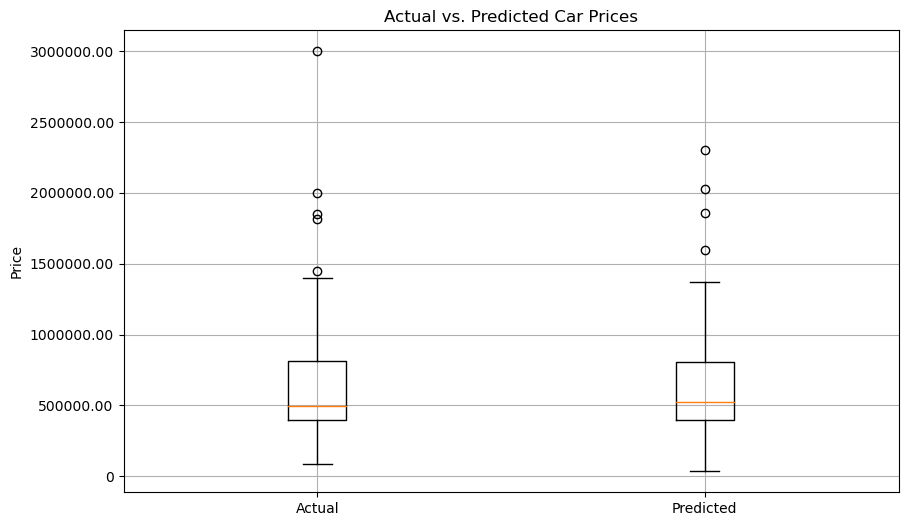

In [30]:
import matplotlib.pyplot as plt

# Plotting the graph using a box plot
plt.figure(figsize=(10, 6))
plt.boxplot([y_test, y_pred], labels=['Actual', 'Predicted'])
plt.title('Actual vs. Predicted Car Prices')
plt.ylabel('Price')
plt.grid(True)

# Setting y-axis tick formatting
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2f}'.format(x) if x >= 10 else '{:.0f}'.format(x)))

plt.show()


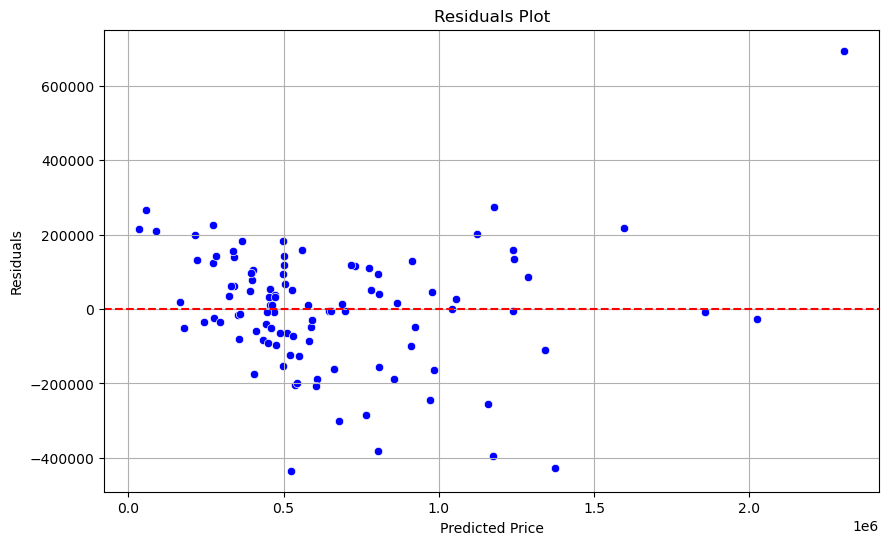

In [37]:
import seaborn as sns

# Calculate residuals
residuals = y_test - y_pred

# Plotting the residuals using Seaborn
plt.figure(figsize=(10, 6))

# Scatter plot with blue points
sns.scatterplot(x=y_pred, y=residuals, color='blue')

# Dotted line with red color
plt.axhline(y=0, color='red', linestyle='--')

plt.title('Residuals Plot')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


In [31]:
new_data = pd.DataFrame({'Company': ['Maruti'], 'Name': ['Maruti Suzuki Swift'], 'Year': [2020], 'Kms_driven': [554750], 'Fuel_type': ['CNG']})
predictions_model1, predicted_price = predict_prices(new_data)
print("Model 1 Predictions (Quantile Regression):", predictions_model1)
print("Model 2 Predicted Price (Linear Regression):", predicted_price)

Model 1 Predictions (Quantile Regression): {0.05: 359765.82743990025, 0.95: 1221331.8285776568}
Model 2 Predicted Price (Linear Regression): 896795.5525325835
